# 所使用的包

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import StandardScaler
import graphviz

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from time import time
import datetime

from sklearn import metrics

# 导入数据

In [2]:
raw_data = pd.read_csv("weatherAUS.csv")
raw_data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


# 删除riskMM 列（含有预测信息）

In [3]:
len_raw = len(raw_data.columns)
data = raw_data.drop('RISK_MM',axis=1)
print("raw_data: {0}, now: {1}".format(len_raw,len(data.columns)))

raw_data: 24, now: 23


# 方法：确认缺失值以及数据类型

In [4]:
def check_missing_val(data):
    variable=[]
    total_val=[]
    data_type = []
    total_missing_val=[]
    missing_val_rate=[]
    for col in data.columns:
      val = data[col]
      variable.append(col)
      data_type.append(val.dtype)
      total_val.append(val.shape[0])
      total_missing_val.append(val.isnull().sum())
      missing_val_rate.append(round(val.isnull().sum()/val.shape[0],3)*100)
        
    # show result
    missing_data=pd.DataFrame({"Variable":variable, "data_type":data_type, "Total_Val":total_val,\
                               "Total_Missing_Val":total_missing_val,"Missing_Val_Rate":missing_val_rate})\
                               .sort_values("Missing_Val_Rate",ascending=False)
    return missing_data

# 查看当前数据缺失情况

In [5]:
data_info=check_missing_val(data)
data_info

,Variable,data_type,Total_Val,Total_Missing_Val,Missing_Val_Rate
6,Sunshine,float64,142193,67816,47.7
5,Evaporation,float64,142193,60843,42.8
18,Cloud3pm,float64,142193,57094,40.2
17,Cloud9am,float64,142193,53657,37.7
15,Pressure9am,float64,142193,14014,9.9
16,Pressure3pm,float64,142193,13981,9.8
9,WindDir9am,object,142193,10013,7.0
7,WindGustDir,object,142193,9330,6.6
8,WindGustSpeed,float64,142193,9270,6.5
10,WindDir3pm,object,142193,3778,2.7


# 针对target处理（RainTomorrow）

In [6]:
data['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

Text(0.5, 1.0, 'Target')

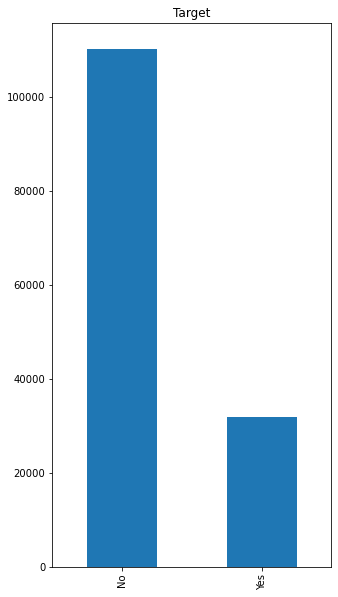

In [7]:
plt.figure(figsize=(5,10))
data['RainTomorrow'].value_counts().plot(kind='bar')
plt.title('Target')
#可见分布不均 后期需要oversampling

In [8]:
data['RainTomorrow'].dtype

dtype('O')

In [9]:
#由于没有缺失值 仅仅需要将 yes --> 1 , no --> 0
data['RainTomorrow']=data['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)
data['RainTomorrow'].describe

<bound method NDFrame.describe of 0         0
1         0
2         0
3         0
4         0
         ..
142188    0
142189    0
142190    0
142191    0
142192    0
Name: RainTomorrow, Length: 142193, dtype: int64>

# 提取日期信息 并将具体日期设置为index

In [10]:
data['Date']=pd.to_datetime(data['Date'])
#提取出月份信息
#每月降雨risk不同
data['Month']=pd.to_datetime(data['Date']).dt.month
data.set_index('Date',inplace=True)

# 将数据集分为 数字型 和 类别型两类

## 方法：获取num或者cate型列名

In [11]:
def get_cate_data(data):
    list_cate = []
    for col in data.columns:
        if data[col].dtype == 'O':
            list_cate.append(col)
    return list_cate

def get_num_data(data):
    list_num = []
    for col in data.columns:
        if data[col].dtype != 'O':
            list_num.append(col)
    return list_num


In [12]:
data_cate = data[get_cate_data(data)]
data_cate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142193 entries, 2008-12-01 to 2017-06-24
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Location     142193 non-null  object
 1   WindGustDir  132863 non-null  object
 2   WindDir9am   132180 non-null  object
 3   WindDir3pm   138415 non-null  object
 4   RainToday    140787 non-null  object
dtypes: object(5)
memory usage: 6.5+ MB


In [13]:
data_num = data.drop(columns=get_cate_data(data))
data_num.info

<bound method DataFrame.info of             MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
Date                                                                           
2008-12-01     13.4     22.9       0.6          NaN       NaN           44.0   
2008-12-02      7.4     25.1       0.0          NaN       NaN           44.0   
2008-12-03     12.9     25.7       0.0          NaN       NaN           46.0   
2008-12-04      9.2     28.0       0.0          NaN       NaN           24.0   
2008-12-05     17.5     32.3       1.0          NaN       NaN           41.0   
...             ...      ...       ...          ...       ...            ...   
2017-06-20      3.5     21.8       0.0          NaN       NaN           31.0   
2017-06-21      2.8     23.4       0.0          NaN       NaN           31.0   
2017-06-22      3.6     25.3       0.0          NaN       NaN           22.0   
2017-06-23      5.4     26.9       0.0          NaN       NaN           37.0   
2017-06-

# 对于cate类数据缺失值处理

In [14]:
data = data.dropna(subset=get_cate_data(data))
data_info=check_missing_val(data[get_cate_data(data)])
data_info

,Variable,data_type,Total_Val,Total_Missing_Val,Missing_Val_Rate
0,Location,object,123710,0,0.0
1,WindGustDir,object,123710,0,0.0
2,WindDir9am,object,123710,0,0.0
3,WindDir3pm,object,123710,0,0.0
4,RainToday,object,123710,0,0.0


# 对于num类数据缺失值处理

In [15]:
list_num = get_num_data(data)
list_num

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainTomorrow',
 'Month']

In [16]:
data_info=check_missing_val(data[list_num])
data_info

,Variable,data_type,Total_Val,Total_Missing_Val,Missing_Val_Rate
4,Sunshine,float64,123710,56623,45.8
3,Evaporation,float64,123710,50647,40.9
13,Cloud3pm,float64,123710,48233,39.0
12,Cloud9am,float64,123710,46234,37.4
10,Pressure9am,float64,123710,9120,7.4
11,Pressure3pm,float64,123710,9069,7.3
9,Humidity3pm,float64,123710,1522,1.2
8,Humidity9am,float64,123710,1012,0.8
15,Temp3pm,float64,123710,795,0.6
14,Temp9am,float64,123710,343,0.3


## 删除缺失率高于35%的4列

In [17]:
data = data.drop(columns=['Sunshine','Evaporation','Cloud3pm','Cloud9am'])
list_num = get_num_data(data)
list_num

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm',
 'RainTomorrow',
 'Month']

## 对于风速 阵风速 降雨量 湿度 
--因其可观察以日期为横轴为连续数据
--采用 插值法 进行填补空值

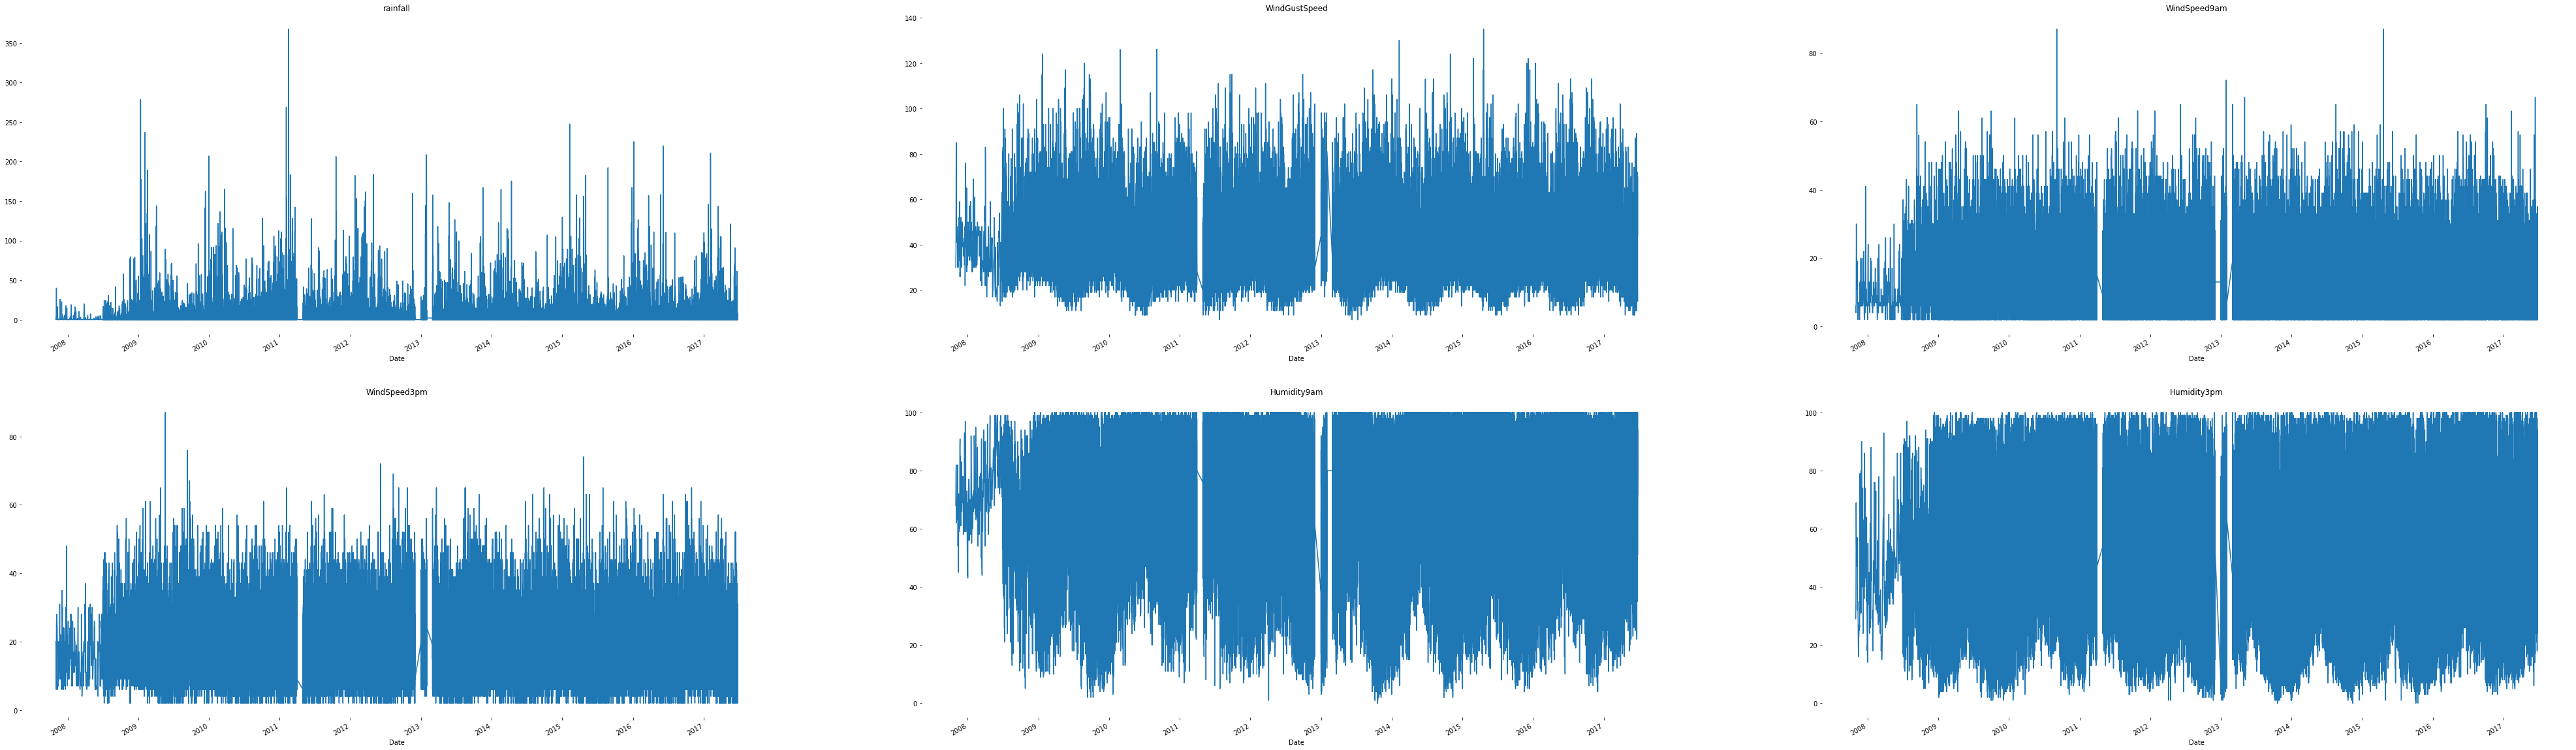

In [18]:
def visual_num():
    plt.figure(figsize=(70,70))
    # rainfall
    plt.subplot(6,3,1)
    data['Rainfall'].plot()
    plt.box(False)
    plt.title ('rainfall')
    # gust
    plt.subplot(6,3,2)
    data['WindGustSpeed'].plot()
    plt.box(False)
    plt.title ('WindGustSpeed')
    # WindSpeed9am
    plt.subplot(6,3,3)
    data['WindSpeed9am'].plot()
    plt.box(False)
    plt.title ('WindSpeed9am')
    # WindSpeed3pm
    plt.subplot(6,3,4)
    data['WindSpeed3pm'].plot()
    plt.box(False)
    plt.title ('WindSpeed3pm')
    # Humidity9am
    plt.subplot(6,3,5)
    data['Humidity9am'].plot()
    plt.box(False)
    plt.title ('Humidity9am')
    # Humidity9am
    plt.subplot(6,3,6)
    data['Humidity3pm'].plot()
    plt.box(False)
    plt.title ('Humidity3pm')
visual_num()


In [19]:
for col in ['Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm']:
    data[col] = data[col].interpolate()
    
data_info=check_missing_val(data[['Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm']])
data_info



,Variable,data_type,Total_Val,Total_Missing_Val,Missing_Val_Rate
0,Rainfall,float64,123710,0,0.0
1,WindGustSpeed,float64,123710,0,0.0
2,WindSpeed9am,float64,123710,0,0.0
3,WindSpeed3pm,float64,123710,0,0.0
4,Humidity9am,float64,123710,0,0.0
5,Humidity3pm,float64,123710,0,0.0


In [20]:
data_info=check_missing_val(data[list_num])
data_info

,Variable,data_type,Total_Val,Total_Missing_Val,Missing_Val_Rate
8,Pressure9am,float64,123710,9120,7.4
9,Pressure3pm,float64,123710,9069,7.3
11,Temp3pm,float64,123710,795,0.6
10,Temp9am,float64,123710,343,0.3
0,MinTemp,float64,123710,90,0.1
1,MaxTemp,float64,123710,45,0.0
2,Rainfall,float64,123710,0,0.0
3,WindGustSpeed,float64,123710,0,0.0
4,WindSpeed9am,float64,123710,0,0.0
5,WindSpeed3pm,float64,123710,0,0.0


## 针对剩余6列: 气压9 气压3 温度9 温度3 最高温度 最低温度
查看其分布情况

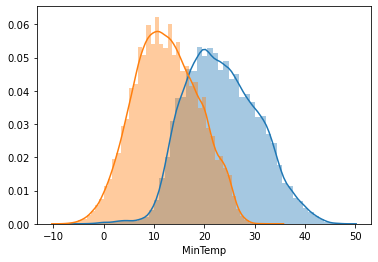

In [21]:
sns.distplot(data['MaxTemp'])
sns.distplot(data['MinTemp'])

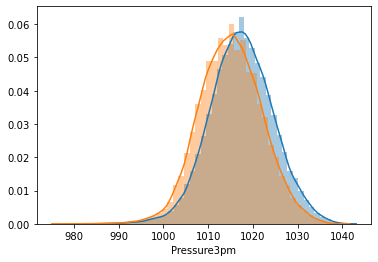

In [22]:
sns.distplot(data['Pressure9am'])
sns.distplot(data['Pressure3pm'])

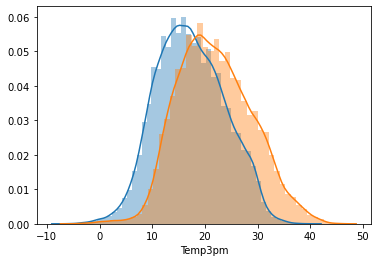

In [23]:
sns.distplot(data['Temp9am'])
sns.distplot(data['Temp3pm'])

In [24]:
len(data.columns)

19

In [25]:
## 对于 min max temp
## 删除同为空的行
data['count_temp'] = data['MaxTemp'].isnull()*1 + data['MinTemp'].isnull()*1
len(data.columns)

20

In [26]:
data['count_temp'].value_counts()

0    123583
1       119
2         8
Name: count_temp, dtype: int64

In [27]:
data = data[data['count_temp']!=2]
data['count_temp'].value_counts()

0    123583
1       119
Name: count_temp, dtype: int64

In [28]:
temp_t = data[data['count_temp']==0].copy()
temp_t['diff']=temp_t['MaxTemp']-temp_t['MinTemp']
mean_diff = temp_t['diff'].mean()
round(mean_diff,1)

11.1

In [29]:
data_info=check_missing_val(data[['MaxTemp','MinTemp']])
data_info

,Variable,data_type,Total_Val,Total_Missing_Val,Missing_Val_Rate
1,MinTemp,float64,123702,82,0.1
0,MaxTemp,float64,123702,37,0.0


In [30]:
# 对于最大温度为空的项 等于 最低温度加上平均差
# 对于最低温度为空的项 等于 最高温度加上平均差
for row in range(data.shape[0]):
    if pd.isna(data.iloc[row]['MaxTemp']) == True:
        data.iloc[row,data.columns == 'MaxTemp'] = (data.iloc[row]['MinTemp'] + mean_diff)
    if pd.isna(data.iloc[row]['MinTemp']) == True:
        data.iloc[row,data.columns == 'MinTemp'] = (data.iloc[row]['MaxTemp'] - mean_diff)
        


In [31]:
data_info=check_missing_val(data[['MaxTemp','MinTemp']])
data_info

,Variable,data_type,Total_Val,Total_Missing_Val,Missing_Val_Rate
0,MaxTemp,float64,123702,0,0.0
1,MinTemp,float64,123702,0,0.0


In [32]:
data = data.drop('count_temp',axis=1)

### 方法类同与温度继续填充剩下4列

In [33]:
# 填充Temp3pm，Temp9am
data['count_daytemp'] = data['Temp3pm'].isnull()*1 + data['Temp9am'].isnull()*1
data = data[data['count_daytemp']!=2]
temp_dt = data[data['count_daytemp']==0].copy()
temp_dt['diff']=temp_dt['Temp9am']-temp_dt['Temp3pm']
mean_diff_dt = temp_dt['diff'].mean()
round(mean_diff_dt,1)
data = data.drop('count_daytemp',axis=1)

# 填充 Pressure9am Pressure3pm
data['count_press'] = data['Pressure9am'].isnull()*1 + data['Pressure3pm'].isnull()*1
data = data[data['count_press']!=2]
temp_press = data[data['count_press']==0].copy()
temp_press['diff']=temp_press['Pressure9am']-temp_press['Pressure3pm']
mean_diff_press = temp_press['diff'].mean()
round(mean_diff_press,1)
data = data.drop('count_press',axis=1)


for row in range(data.shape[0]):
    if pd.isna(data.iloc[row]['Temp9am']) == True:
        data.iloc[row,data.columns == 'Temp9am'] = (data.iloc[row]['Temp3pm'] + mean_diff_dt)
    if pd.isna(data.iloc[row]['Temp3pm']) == True:
        data.iloc[row,data.columns == 'Temp3pm'] = (data.iloc[row]['Temp9am'] - mean_diff_dt)
    if pd.isna(data.iloc[row]['Pressure9am']) == True:
        data.iloc[row,data.columns == 'Pressure9am'] = (data.iloc[row]['Pressure3pm'] + mean_diff_press)
    if pd.isna(data.iloc[row]['Pressure3pm']) == True:
        data.iloc[row,data.columns == 'Pressure3pm'] = (data.iloc[row]['Pressure9am'] - mean_diff_press)



In [34]:
data_info=check_missing_val(data)
data_info

,Variable,data_type,Total_Val,Total_Missing_Val,Missing_Val_Rate
0,Location,object,114657,0,0.0
10,Humidity9am,float64,114657,0,0.0
17,RainTomorrow,int64,114657,0,0.0
16,RainToday,object,114657,0,0.0
15,Temp3pm,float64,114657,0,0.0
14,Temp9am,float64,114657,0,0.0
13,Pressure3pm,float64,114657,0,0.0
12,Pressure9am,float64,114657,0,0.0
11,Humidity3pm,float64,114657,0,0.0
9,WindSpeed3pm,float64,114657,0,0.0


# 特征工程

## 针对cate类列 进行高维映射
month raintoday windir9 windir3 wingust location

In [35]:
#raintoday 
data['RainToday'].value_counts()

No     88853
Yes    25804
Name: RainToday, dtype: int64

In [36]:
data['RainToday']=data['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)
data['RainToday'].value_counts()

0    88853
1    25804
Name: RainToday, dtype: int64

In [37]:
## 进行高维映射
# temp_lvl = data[['Month','WindDir9am','WindDir3pm','WindGustDir','Location']].copy()
# temp_lvl = pd.get_dummies(temp_lvl)
# for col in temp_lvl.columns:
#     data[col] = temp_lvl[col]
# data = data.drop(columns=['Month','WindDir9am','WindDir3pm','WindGustDir','Location'])

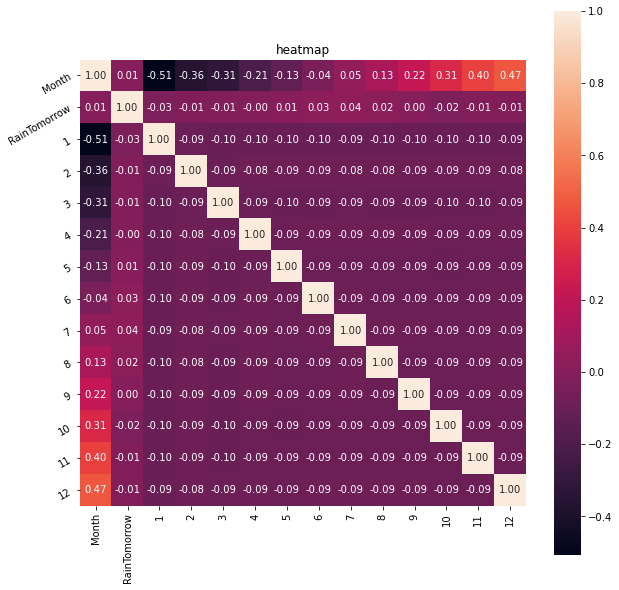

In [38]:
def corr_for_cate(col):
    temp = data[[col,'RainTomorrow']].copy()
    temp_dum = pd.get_dummies(temp[col])
    for col in temp_dum.columns:
        temp[col] = temp_dum[col]
    return temp


plt.figure(figsize=(10,10))
plt.title('heatmap')
ax = sns.heatmap(corr_for_cate('Month').corr(), square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

# 由此可以看出 月份可以有效的分为10-3月，相关度更加高，和其他月份
# 10-3月 --》 1 or 其他 --〉0


In [39]:
data['Month_10to3']=data['Month'].apply(lambda x: 1 if x in [1,2,3,10,11,12] else 0)
data=data.drop('Month',axis=1)
data['Month_10to3'].value_counts()

1    58408
0    56249
Name: Month_10to3, dtype: int64

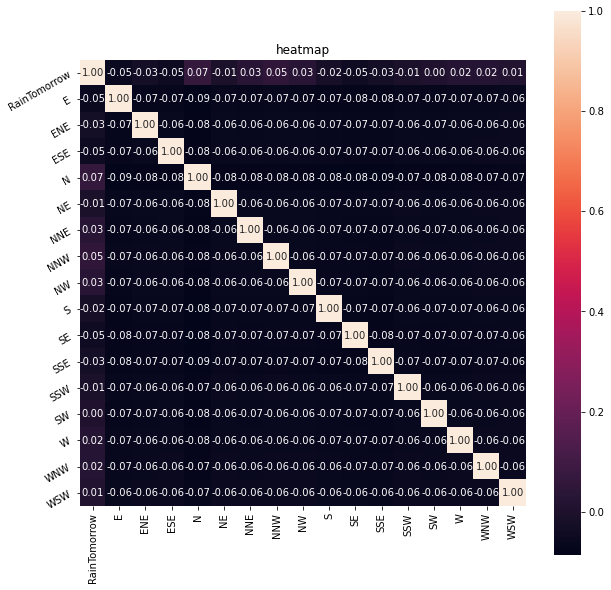

In [40]:
## windir9am
plt.figure(figsize=(10,10))
plt.title('heatmap')
ax = sns.heatmap(corr_for_cate('WindDir9am').corr(), square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()
# 所有项 相关度过低删除dir9am项

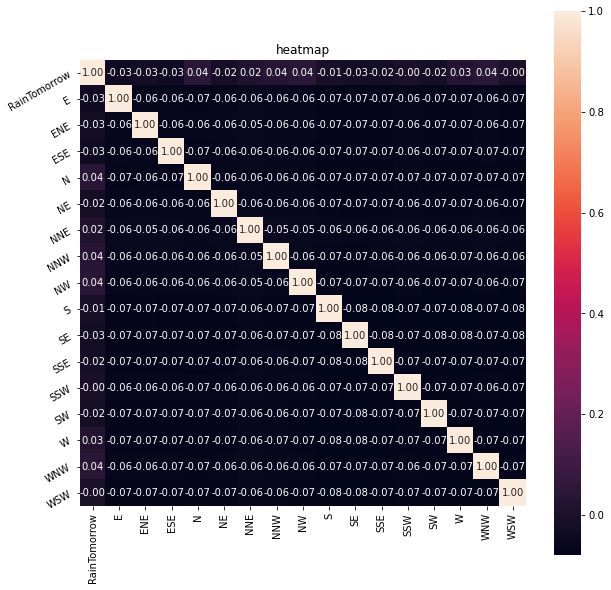

In [41]:
## windir3pm
plt.figure(figsize=(10,10))
plt.title('heatmap')
ax = sns.heatmap(corr_for_cate('WindDir3pm').corr(), square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()
#  所有项 相关度过低删除windir3pm项

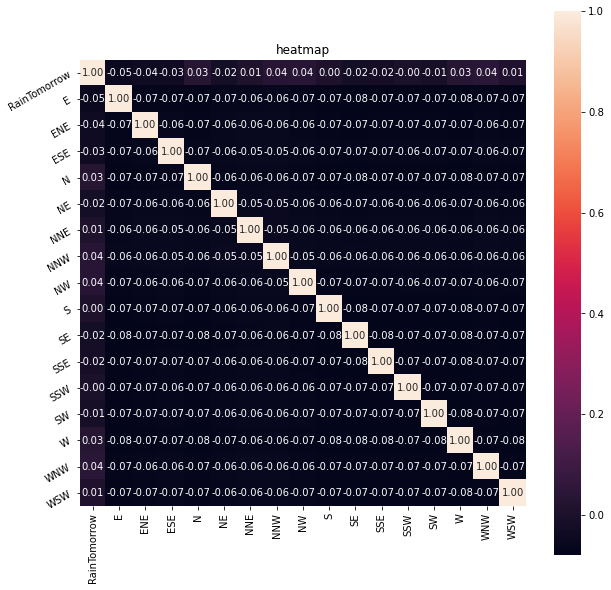

In [42]:
## WindGustDir
plt.figure(figsize=(10,10))
plt.title('heatmap')
ax = sns.heatmap(corr_for_cate('WindGustDir').corr(), square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()
#  所有项 相关度过低删除WindGustDir项
## 总结： 风向和下雨关联性不大可以删除

In [43]:
data = data.drop(['WindGustDir','WindDir9am','WindDir3pm'],axis=1)

In [44]:
corr_for_cate('Location').corr()

,RainTomorrow,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
RainTomorrow,1.000000,0.002357,-0.001961,-0.052366,-0.007321,0.015387,-0.011961,-0.001289,0.035634,-0.014351,...,-0.019959,-0.012548,-0.039659,-0.015430,0.044499,0.010977,0.003652,0.030055,0.006220,-0.060550
Adelaide,0.002357,1.000000,-0.023114,-0.024533,-0.022651,-0.025121,-0.024414,-0.025789,-0.025224,-0.024601,...,-0.025152,-0.022513,-0.017697,-0.024779,-0.023407,-0.024524,-0.021901,-0.023545,-0.024774,-0.025300
Albury,-0.001961,-0.023114,1.000000,-0.023127,-0.021353,-0.023681,-0.023014,-0.024311,-0.023778,-0.023191,...,-0.023711,-0.021222,-0.016682,-0.023359,-0.022065,-0.023118,-0.020646,-0.022195,-0.023354,-0.023850
AliceSprings,-0.052366,-0.024533,-0.023127,1.000000,-0.022663,-0.025135,-0.024427,-0.025804,-0.025238,-0.024615,...,-0.025167,-0.022525,-0.017707,-0.024793,-0.023420,-0.024537,-0.021914,-0.023558,-0.024788,-0.025314
BadgerysCreek,-0.007321,-0.022651,-0.021353,-0.022663,1.000000,-0.023207,-0.022553,-0.023824,-0.023302,-0.022727,...,-0.023236,-0.020797,-0.016348,-0.022891,-0.021623,-0.022655,-0.020232,-0.021751,-0.022886,-0.023372
Ballarat,0.015387,-0.025121,-0.023681,-0.025135,-0.023207,1.000000,-0.025013,-0.026423,-0.025843,-0.025205,...,-0.025770,-0.023065,-0.018131,-0.025387,-0.023982,-0.025126,-0.022439,-0.024123,-0.025383,-0.025921
Bendigo,-0.011961,-0.024414,-0.023014,-0.024427,-0.022553,-0.025013,1.000000,-0.025678,-0.025115,-0.024495,...,-0.025044,-0.022416,-0.017621,-0.024672,-0.023306,-0.024418,-0.021807,-0.023444,-0.024668,-0.025191
Brisbane,-0.001289,-0.025789,-0.024311,-0.025804,-0.023824,-0.026423,-0.025678,1.000000,-0.026531,-0.025876,...,-0.026456,-0.023679,-0.018614,-0.026063,-0.024619,-0.025794,-0.023036,-0.024765,-0.026058,-0.026611
Cairns,0.035634,-0.025224,-0.023778,-0.025238,-0.023302,-0.025843,-0.025115,-0.026531,1.000000,-0.025309,...,-0.025876,-0.023160,-0.018205,-0.025491,-0.024080,-0.025229,-0.022531,-0.024222,-0.025486,-0.026027
Canberra,-0.014351,-0.024601,-0.023191,-0.024615,-0.022727,-0.025205,-0.024495,-0.025876,-0.025309,1.000000,...,-0.025237,-0.022588,-0.017756,-0.024862,-0.023485,-0.024606,-0.021975,-0.023624,-0.024857,-0.025385


In [45]:
## 同样删除location信息 相关度太差
data = data.drop(['Location'],axis=1)

# 对num类的数据进行分析

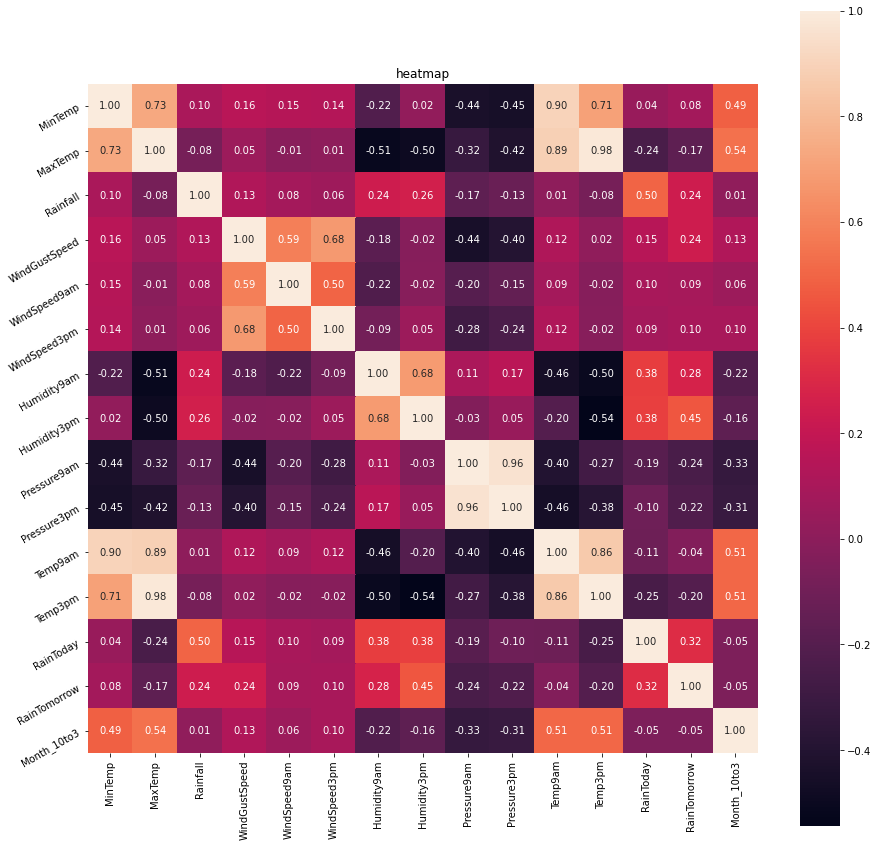

In [46]:
plt.figure(figsize=(15,15))
plt.title('heatmap')
ax = sns.heatmap(data.corr(), square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

## 相关度较高项： 
### a. mintemp maxtemp temp9 temp3 
### b. humidity9 humidity3 
### c. press9 press3 

In [47]:
#a. mintemp maxtemp temp9 temp3 
temp_temp = data[['RainTomorrow','MinTemp','MaxTemp','Temp9am','Temp3pm']].copy()
temp_temp['temp_range'] = temp_temp['MaxTemp'] - temp_temp['MinTemp']
temp_temp['mean_temp']=(temp_temp['Temp9am']+temp_temp['Temp3pm'])/2
temp_temp['std_temp']=temp_temp['Temp9am']-temp_temp['Temp3pm']
temp_temp['std_temp']=temp_temp['std_temp'].apply(lambda x: abs(x))
temp_temp.corr()

# 对于predict下雨，temp_range 和 std_temp 相关度最高， 但自身二者相关较高 所以取 range
# 其他几列互相的相关度都比较高 取对于预测最有帮助的一个 temp3

#因此，取 range 和 temp3 代表 温度类

,RainTomorrow,MinTemp,MaxTemp,Temp9am,Temp3pm,temp_range,mean_temp,std_temp
RainTomorrow,1.000000,0.077693,-0.169395,-0.036547,-0.203187,-0.341025,-0.127380,-0.295437
MinTemp,0.077693,1.000000,0.731923,0.899448,0.708170,-0.230832,0.829363,-0.231996
MaxTemp,-0.169395,0.731923,1.000000,0.886607,0.984197,0.494034,0.971213,0.343008
Temp9am,-0.036547,0.899448,0.886607,1.000000,0.862136,0.118353,0.962255,-0.102913
Temp3pm,-0.203187,0.708170,0.984197,0.862136,1.000000,0.501777,0.967486,0.392023
temp_range,-0.341025,-0.230832,0.494034,0.118353,0.501777,1.000000,0.328596,0.785826
mean_temp,-0.127380,0.829363,0.971213,0.962255,0.967486,0.328596,1.000000,0.159193
std_temp,-0.295437,-0.231996,0.343008,-0.102913,0.392023,0.785826,0.159193,1.000000


In [48]:
data['temp_range'] = data['MaxTemp'] - data['MinTemp']
data=data.drop(columns=['MinTemp','MaxTemp','Temp9am'],axis=1)

In [49]:
#b. humidity9 humidity3
temp_humi = data[['RainTomorrow','Humidity9am','Humidity3pm']].copy()
temp_humi['mean-humi'] = (temp_humi['Humidity9am']+temp_humi['Humidity3pm'])/2
temp_humi['std-humi'] = temp_humi['Humidity9am']-temp_humi['Humidity3pm']
temp_humi['std-humi'] = temp_humi['std-humi'].apply(lambda x: abs(x))
temp_humi.corr()
# 均值和标准差反而效果不好
# 取humi3

,RainTomorrow,Humidity9am,Humidity3pm,mean-humi,std-humi
RainTomorrow,1.000000,0.275327,0.452524,0.400847,-0.175474
Humidity9am,0.275327,1.000000,0.683859,0.909723,0.273953
Humidity3pm,0.452524,0.683859,1.000000,0.925069,-0.387406
mean-humi,0.400847,0.909723,0.925069,1.000000,-0.077864
std-humi,-0.175474,0.273953,-0.387406,-0.077864,1.000000


In [50]:
data = data.drop('Humidity9am',axis=1)

In [51]:
#c. press9 press3 
#增加气压标准差值栏
temp_press1 = data[['RainTomorrow','Pressure9am','Pressure3pm']].copy()
temp_press1['d-value'] = temp_press1['Pressure9am']-temp_press1['Pressure3pm']
temp_press1['d-value'] = temp_press1['d-value'].apply(lambda x: abs(x))
#增加折中气压
temp_press1['mean-value'] = (temp_press1['Pressure9am']+temp_press1['Pressure3pm'])/2
#temp_press1.head(10)
temp_press1.corr()
#效果不明显 同样取效果稍好的press9

,RainTomorrow,Pressure9am,Pressure3pm,d-value,mean-value
RainTomorrow,1.000000,-0.244210,-0.223881,-0.025705,-0.236460
Pressure9am,-0.244210,1.000000,0.960173,0.023824,0.990088
Pressure3pm,-0.223881,0.960173,1.000000,-0.193247,0.989898
d-value,-0.025705,0.023824,-0.193247,1.000000,-0.085050
mean-value,-0.236460,0.990088,0.989898,-0.085050,1.000000


In [52]:
data = data.drop('Pressure3pm',axis=1)

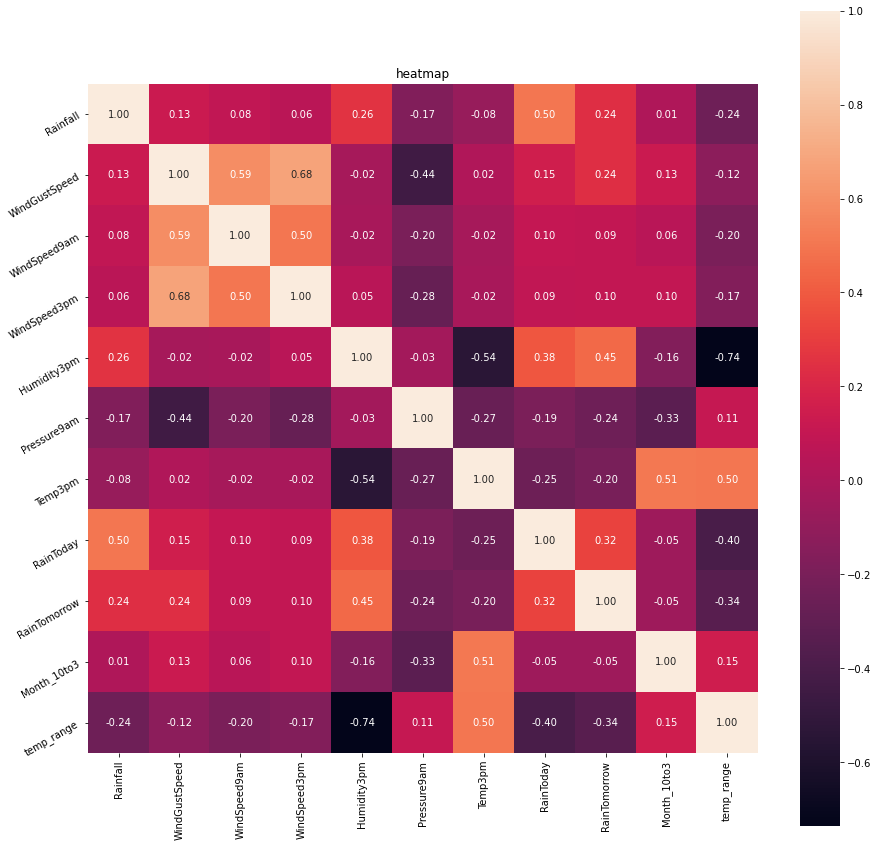

In [53]:
#重新测试热力图
plt.figure(figsize=(15,15))
plt.title('heatmap')
ax = sns.heatmap(data.corr(), square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

# 划分数据集

In [54]:
# X y
X = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [55]:
X_train.shape

(91725, 10)

In [56]:
X_test.shape

(22932, 10)

# 模型初步

# 决策树模型
X_train, X_test, y_train, y_test

In [58]:

DTC = tree.DecisionTreeClassifier()
DTC = DTC.fit(X_train,y_train)
score_train = DTC.score(X_train,y_train)
score_test = DTC.score(X_test,y_test)
print("train_score: {0}, test_score: {1}".format(score_train,score_test))

train_score: 1.0, test_score: 0.7741147741147741


通过train的准确度分数已经达到1，而test的准确度仅仅0.77
说明书模型存在过度拟合
进行调参

In [59]:
# 观差所有列的贡献度
feature_name = list(X_train.columns)
[*zip(feature_name,DTC.feature_importances_)]


[('Rainfall', 0.06211993174735864),
 ('WindGustSpeed', 0.10262504929218404),
 ('WindSpeed9am', 0.06684857284984294),
 ('WindSpeed3pm', 0.06844978383193033),
 ('Humidity3pm', 0.3261893627759103),
 ('Pressure9am', 0.1295306464312161),
 ('Temp3pm', 0.12217794457235644),
 ('RainToday', 0.0022001243556071465),
 ('Month_10to3', 0.010487906782120247),
 ('temp_range', 0.10937067736147378)]

设置参数：
criterion：计算不纯度 使用gini基数的方法
random_state :设置为30，固定生成随机系数为30的树来消除决策树的随机性问题
max_depth:限制生成树的最大深度 

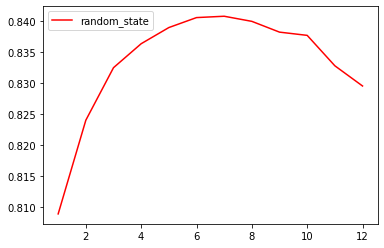

In [60]:
#通过超参数图 找出max_depth最优点
test = []
for i in range(12):
    DTC = tree.DecisionTreeClassifier(criterion = "gini"
                                      ,random_state = 30
                                      ,max_depth= i+1
                                      )
    DTC = DTC.fit(X_train,y_train)
    score = DTC.score(X_test,y_test)
    test.append(score)
plt.plot(range(1,13),test,color="red",label="random_state")
plt.legend()
plt.show()

In [61]:
# 8 为最优点 模型准确度最高
DTC = tree.DecisionTreeClassifier(criterion = "gini"
                                      ,random_state = 30
                                      ,max_depth= 8
                                )
DTC = DTC.fit(X_train,y_train)
score_train = DTC.score(X_train,y_train)
score_test = DTC.score(X_test,y_test)
print("train_score: {0}, test_score: {1}".format(score_train,score_test))

train_score: 0.8525919869174162, test_score: 0.8400052328623757


In [62]:
#调整splitter（默认为best）
#调整为 随机选分枝
DTC = tree.DecisionTreeClassifier(criterion = "gini"
                                      ,random_state = 30
                                      ,max_depth= 8
                                      ,splitter="random"
                                )
DTC = DTC.fit(X_train,y_train)
score_train = DTC.score(X_train,y_train)
score_test = DTC.score(X_test,y_test)
print("train_score: {0}, test_score: {1}".format(score_train,score_test))

train_score: 0.8436086127010084, test_score: 0.8364294435723008


对于splitter：random反而会使准确度降低，还是采用默认best

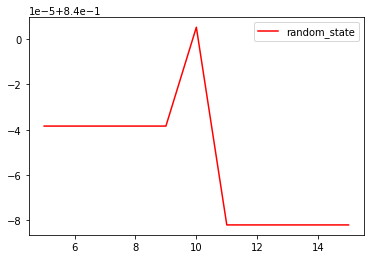

In [63]:
#继续进行剪枝操作
#将min_samples_split放入超参数测试
test = []
for i in range(5,16):
    DTC = tree.DecisionTreeClassifier(criterion = "gini"
                                      ,random_state = 30
                                      ,max_depth= 8
                                      ,min_samples_split = i
                                      )
    DTC = DTC.fit(X_train,y_train)
    score = DTC.score(X_test,y_test)
    test.append(score)
plt.plot(range(5,16),test,color="red",label="random_state")
plt.legend()
plt.show()

## 决策树模型调参总结：
————————————————————————————————
### criterion = "gini"
### random_state = 30
### max_depth= 8
### min_samples_split = 7

In [64]:
DTC = tree.DecisionTreeClassifier(criterion = "gini"
                                      ,random_state = 30
                                      ,max_depth= 8
                                      ,min_samples_split = 7
                                )
DTC = DTC.fit(X_train,y_train)
score_train = DTC.score(X_train,y_train)
score_test = DTC.score(X_test,y_test)
print("决策树最终结果：")
print("train_score: {0}, test_score: {1}".format(score_train,score_test))

决策树最终结果：
train_score: 0.8525592804578904, test_score: 0.8399616256759114


In [65]:
import graphviz
dot_data = tree.export_graphviz(DTC
                                ,feature_names = feature_name
                                ,class_names=['no','yes']
                                ,filled=True
                                ,rounded=True
                                
                                )
graph = graphviz.Source(dot_data)
graph.view()

'Source.gv.pdf'

## 探索归一化是否对数据集拟合效果有提升

In [66]:
#对features 归一化处理
X = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train

array([[-0.22959892, -0.5833522 , -0.25986198, ..., -0.53931909,
        -1.01940881, -0.69150874],
       [-0.27587329,  0.16679894,  0.57933952, ..., -0.53931909,
         0.98096072, -0.16238256],
       [-0.27587329, -0.28329174,  0.57933952, ..., -0.53931909,
        -1.01940881, -0.22343558],
       ...,
       [-0.27587329, -0.5833522 , -1.09906348, ..., -0.53931909,
        -1.01940881,  1.2214859 ],
       [-0.16018737,  1.81713144,  0.21968173, ..., -0.53931909,
        -1.01940881, -0.2844886 ],
       [-0.2527361 ,  1.14199541,  0.81911137, ..., -0.53931909,
         0.98096072, -1.34274095]])

In [67]:
DTC = tree.DecisionTreeClassifier(criterion = "gini"
                                        ,random_state = 30
                                      ,max_depth= 8
                                      ,min_samples_split = 7
                                )
DTC = DTC.fit(X_train,y_train)
score_train = DTC.score(X_train,y_train)
score_test = DTC.score(X_test,y_test)
print("归一后的决策树结果：")
print("train_score: {0}, test_score: {1}".format(score_train,score_test))

归一后的决策树结果：
train_score: 0.8522213137094576, test_score: 0.8380429094714809


### 可以看出归一后的数据拟合效果反而降低 
### 因为对于决策树模型来说 feature间的数量级差异并不会影响其生出树 反而会抹除掉一部分feature包含的信息

## 决策树最终结果：
### train_score: 0.8509566639411283, test_score: 0.8474184545613117

## 随机森林模型

————————————————————————————————————————
### 集成式的模型 （bagging）
### 基于决策树，生成多个评估器
### 一般来说，单个决策树模型的拟合效果越好 森林模型的拟合效果也会约好
### 因此后面决策树相关的参数 选择上面 所选择的
### 划分数据时 改用采用交叉验证的方式 提高获取信息

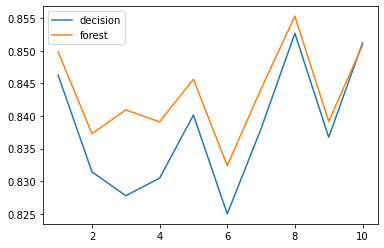

In [68]:
# 比较 决策树 和 随机森林 的拟合效果
X = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']

DTC = tree.DecisionTreeClassifier(criterion = "gini"
                                        ,random_state = 30
                                      ,max_depth= 8
                                      ,min_samples_split = 7
                                ) 
score_DTC = cross_val_score(DTC,X,y,cv=10)
    
RFC = RandomForestClassifier(criterion = "gini"
                                        ,random_state = 30
                                      ,max_depth= 8
                                      ,min_samples_split = 7
                                     ,n_estimators = 25
                                ) 
score_RFC = cross_val_score(RFC,X,y,cv=10)

plt.plot(range(1,11),score_DTC,label='decision')
plt.plot(range(1,11),score_RFC,label='forest')
plt.legend()
plt.show()

### forest的拟合效果比决策树好，而且拟合效果成正比

## 调整生成树的数量n_estimators 到最优

In [69]:
scores = []
for i in range(0,100,10):
    RFC = RandomForestClassifier(criterion = "gini"
                                        ,random_state = 30
                                      ,max_depth= 8
                                      ,min_samples_split = 7
                                     ,n_estimators = i+1
                                    ) 
    score_RFC = cross_val_score(RFC,X,y,cv=10).mean()
    scores.append(score_RFC)


max score: 0.8440741960398057, n_estimators: 51


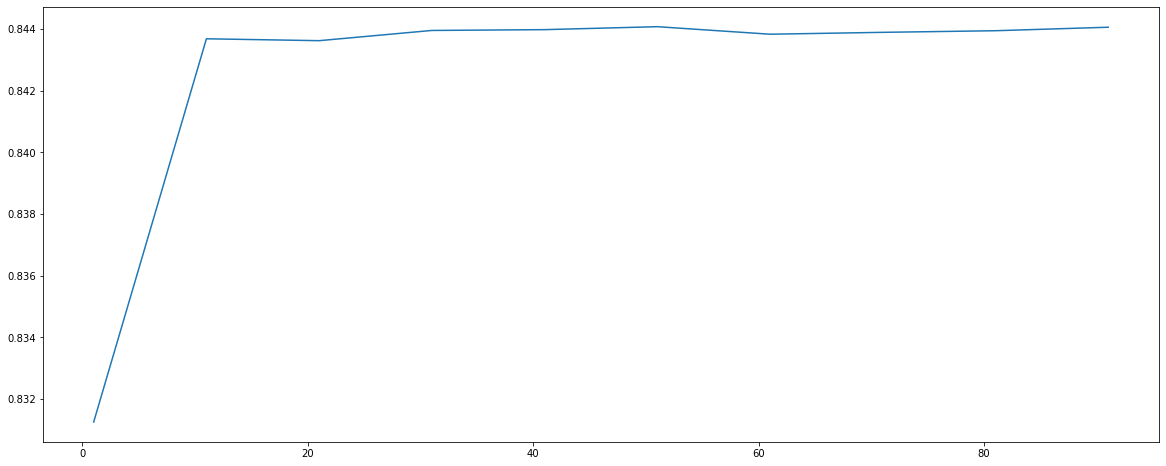

In [70]:
print("max score: {}, n_estimators: {}".format(max(scores),scores.index(max(scores))* 10+1))
plt.figure(figsize=[20,8])
plt.plot(range(1,101,10),scores)
plt.show()


In [71]:
# 进一步精确：
scores = []
for i in range(35,46):
    RFC = RandomForestClassifier(criterion = "gini"
                                        ,random_state = 30
                                      ,max_depth= 8
                                      ,min_samples_split = 7
                                     ,n_estimators = i
                                    ) 
    score_RFC = cross_val_score(RFC,X,y,cv=10).mean()
    scores.append(score_RFC)


max score: 0.8440567569687252, n_estimators: 35


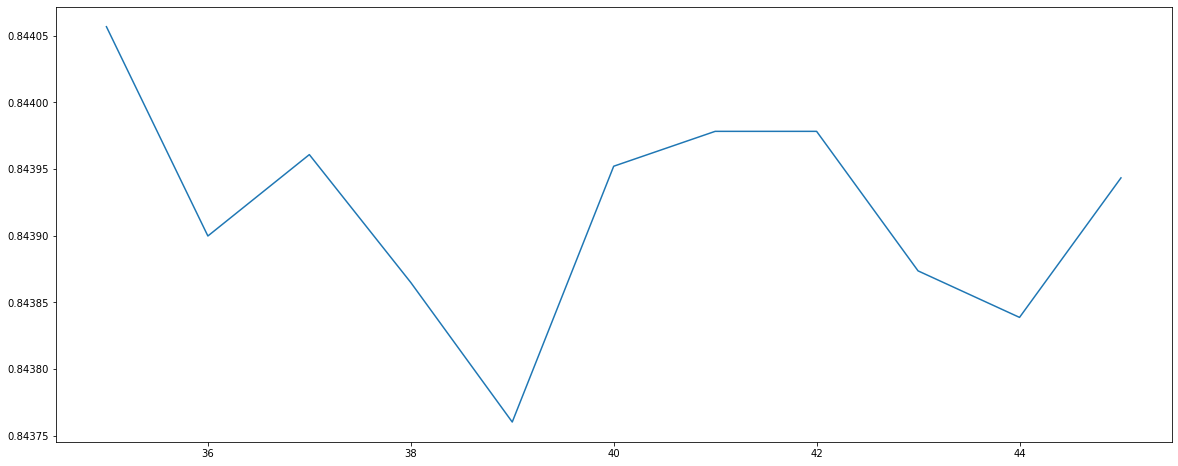

In [72]:
print("max score: {}, n_estimators: {}".format(max(scores),35+scores.index(max(scores))))
plt.figure(figsize=[20,8])
plt.plot(range(35,46),scores)
plt.show()

## 因此，最终n_estimators 选择35
## score = 0.8440567569687252
## 与决策树差别不大

# 向量机模型 svm 
## 通过超平面 划分数据

In [73]:
X = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [74]:
# 并不像决策树 svc对于feature的量级差敏感 过大的数量级差异 会造成拟合效果差
# 为了验证该想法 比较对于归一前后的 准确度

# 线性，高斯核， sigmoid
kernels = ["linear","rbf","sigmoid"] 

for kernel in kernels:
    time0 = time()
    clf = SVC(kernel = kernel
              ,gamma = "auto"
              ,cache_size = 4000
                ).fit(X_train,y_train)

    print("The accuracy under {} is {}".format(kernel,clf.score(X_test,y_test)))
    print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))


The accuracy under linear is 0.847985347985348
08:16:578564
The accuracy under rbf is 0.7826617826617827
12:03:429337
The accuracy under sigmoid is 0.7806994592708878
02:19:226561


In [75]:
# 可以看出归一前的拟合效果不好
# rbf高斯核 和 sigmoid核 仅仅只有78准确率
# 接下来对归一后数据进行拟合

X = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train

array([[-0.21137471,  2.94361108, -0.25842399, ..., -0.53884749,
         0.98042593, -1.30218035],
       [-0.04520036,  0.69188706,  1.78019137, ...,  1.85581268,
        -1.01996486, -0.79415667],
       [ 0.5245403 , -0.80926229, -0.25842399, ...,  1.85581268,
        -1.01996486, -0.69255193],
       ...,
       [ 0.5008011 ,  2.34315134, -0.01858689, ...,  1.85581268,
        -1.01996486, -0.46902151],
       [-0.2825923 , -0.80926229, -0.49826109, ..., -0.53884749,
        -1.01996486, -0.79415667],
       [ 0.95184579, -0.58408989, -0.73809819, ...,  1.85581268,
         0.98042593, -0.5503053 ]])

In [76]:
# 线性，高斯核， sigmoid
kernels = ["linear","rbf","sigmoid"] 
print("After scaler:")
for kernel in kernels:
    time0 = time()
    clf = SVC(kernel = kernel
              ,gamma = "auto"
              ,cache_size = 4000
                ).fit(X_train,y_train)

    print("The accuracy under {} is {}".format(kernel,clf.score(X_test,y_test)))
    print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))



After scaler:
The accuracy under linear is 0.8461538461538461
04:03:471139
The accuracy under rbf is 0.8490319204604919
03:12:237914
The accuracy under sigmoid is 0.7656549799406942
05:27:068044


## 通过对比得出归一化对于svc拟合提升效果明显
### 另外：准确度在线性核 下 表现情况良好 所以该数据集呈现线性趋势
## 最终还是选择准确度最高的高斯核rbf（高斯核当前表现最佳且能进一步调参）

## 调整参数gamma值 -------

0.847985347985348 0.0359381366380464


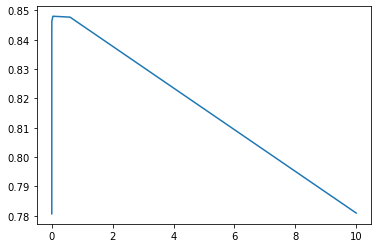

In [77]:
scores = []
gamma_range = np.logspace(-10,1,10)
for gamma in gamma_range:
    clf = SVC(kernel = "rbf"
              ,gamma= gamma
              ,cache_size = 5000
                ).fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    scores.append(score)
    
#给出最大值，并返回最大值的索引
print(max(scores),gamma_range[scores.index(max(scores))])
plt.plot(gamma_range,scores)
plt.show()
      

### gamma=0.0359381366380464 时 准确率最高为0.847985347985348

## 调整label两个分类的硬间隔和软间隔 
## 惩罚项系数 c ------ 松弛系数

0.8492935635792779 8.0


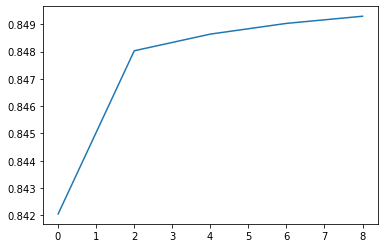

In [84]:
scores = []
c_range = np.linspace(0.01,8,5)
for i in c_range:
    clf = SVC(kernel = "rbf"
              ,gamma=  0.0359381366380464
              ,cache_size = 5000
              ,C=i
                ).fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    scores.append(score)
    
#给出最大值，并返回最大值的索引
print(max(scores),c_range[scores.index(max(scores))])
plt.plot(c_range,scores)
plt.show()

0.8493371707657422 12.0


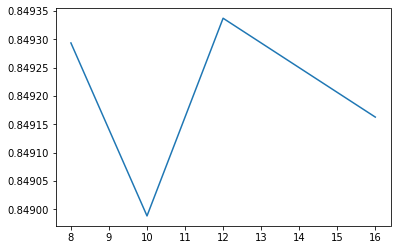

In [85]:
#可以看出在（0，8）之间随着c的提升 拟合效果也随之提高 且没有趋于平稳 或发生拐点
#继续延伸range范围 
scores = []
c_range = np.linspace(8,16,5)
for i in c_range:
    clf = SVC(kernel = "rbf"
              ,gamma=  0.0359381366380464
              ,cache_size = 5000
              ,C=i
                ).fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    scores.append(score)
    
#给出最大值，并返回最大值的索引
print(max(scores),c_range[scores.index(max(scores))])
plt.plot(c_range,scores)
plt.show()

## 松弛系数 c 在12时 拟合效果最好

In [87]:
time0 = time()
clf = SVC(kernel = "rbf"
          ,gamma = 0.0359381366380464
          ,cache_size = 5000
          ,C= 12
            ).fit(X_train,y_train)

print("The final accuracy is {}".format(clf.score(X_test,y_test)))
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

The final accuracy is 0.8493371707657422
04:05:896315


# 综合三个模型比较拟合情况

In [ ]:
### 决策树

In [92]:
# X y
X = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)



In [93]:
DTC = tree.DecisionTreeClassifier(criterion = "gini"
                                      ,random_state = 30
                                      ,max_depth= 8
                                      ,min_samples_split = 7
                                )
DTC = DTC.fit(X_train,y_train)
# score_train = DTC.score(X_train,y_train)
# score_test = DTC.score(X_test,y_test)
pred = DTC.predict(X_test)

In [94]:
print("决策树最终结果：")

print('acc:\n',metrics.accuracy_score(y_test,pred))
print('f1:\n',metrics.f1_score(y_test,pred))
print('matrix:\n',metrics.confusion_matrix(y_test,pred))

决策树最终结果：
acc:
 0.8462410605267748
f1:
 0.5846878680800942
matrix:
 [[16924  1042]
 [ 2484  2482]]


In [95]:
### 随机森林

In [99]:
RFC = RandomForestClassifier(criterion = "gini"
                                    ,random_state = 30
                                  ,max_depth= 8
                                  ,min_samples_split = 7
                                 ,n_estimators = 35
                                ) 
pred = cross_val_predict(RFC,X,y,cv=10)



In [101]:
print("随机森林最终结果：")
print('acc:\n',metrics.accuracy_score(y,pred))
print('f1:\n',metrics.f1_score(y,pred))
print('matrix:\n',metrics.confusion_matrix(y,pred))

随机森林最终结果：
acc:
 0.8440566210523561
f1:
 0.5576666171886596
matrix:
 [[85506  3711]
 [14169 11271]]


In [ ]:
### svc

In [104]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [105]:
clf = SVC(kernel = "rbf"
          ,gamma = 0.0359381366380464
          ,cache_size = 5000
          ,C= 12
            ).fit(X_train,y_train)
pred = clf.predict(X_test)

In [106]:
print("svc最终结果：")

print('acc:\n',metrics.accuracy_score(y_test,pred))
print('f1:\n',metrics.f1_score(y_test,pred))
print('matrix:\n',metrics.confusion_matrix(y_test,pred))

svc最终结果：
acc:
 0.8536106750392465
f1:
 0.5709904153354632
matrix:
 [[17341   625]
 [ 2732  2234]]
